<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-Bethe-lattice-subgraph" data-toc-modified-id="Create-a-Bethe-lattice-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a Bethe lattice subgraph</a></span></li><li><span><a href="#Get-contraction-cost-estimations" data-toc-modified-id="Get-contraction-cost-estimations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get contraction cost estimations</a></span></li><li><span><a href="#Bethe-lattice-subgraphs-complexity-estimation" data-toc-modified-id="Bethe-lattice-subgraphs-complexity-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bethe lattice subgraphs complexity estimation</a></span></li></ul></div>

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import qtensor as qt
from cartesian_explorer import Explorer, parallels, caches
import cartesian_explorer.caches as caches


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
parallel = parallels.Ray()
cache = caches.JobLibCache('../../../data/a/cache/skylake_tree/')
ex = Explorer(parallel=parallel, cache=cache)

2020-11-25 00:56:35,781	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


## Create a Bethe lattice subgraph

In [9]:
@ex.provider
def bethe_graph(p, degree):
    def add_two_nodes_to_leafs(graph):
        """ Works in-place """
        leaves = [n for n in graph.nodes() if graph.degree(n) <= degree-2]
        n = graph.number_of_nodes()
        for leaf in leaves:
            next_edges = [(leaf, n+x) for x in range(1, degree)]
            graph.add_edges_from(next_edges)
            n += 2
    graph = nx.Graph()
    graph.add_edges_from([(0,1)])
    for i in range(p):
        add_two_nodes_to_leafs(graph)
    print('bethe lattice nodes', graph.number_of_nodes())
    return graph



bethe lattice nodes 30


Text(0.5, 1.0, 'Bethe lattice subgraph for p=4')

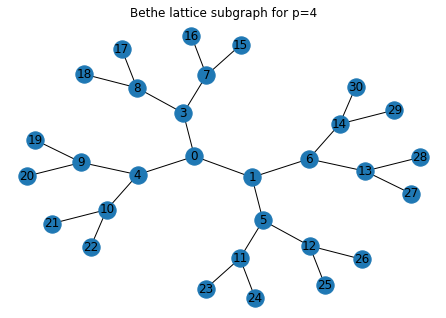

In [10]:
G = bethe_graph(p=3, degree=3)
nx.draw_kamada_kawai(G, with_labels=True)
plt.title('Bethe lattice subgraph for p=4')

In [24]:
@ex.provider
def bethe_lightcone_circuit(bethe_graph, beta, gamma, composer_type='cone'):
    if composer_type=='cone':
        Composer = qt.QtreeQAOAComposer
    elif composer_type=='cylinder':
        Composer = qt.OldQtreeQAOAComposer
    elif composer_type=='zz':
        Composer = qt.ZZQtreeQAOAComposer
    elif composer_type=='zz_simp':
        Composer = qt.SimpZZQtreeComposer
    else:
        raise Exception(f'Composer {composer_type} is not supported')
    
    print('beta, gamma', beta, gamma, 'type', composer_type)
    comp = Composer(bethe_graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone((0, 1))
    print('len', len(comp.circuit))
    return tuple(comp.circuit)
    

In [25]:
circ1 = bethe_lightcone_circuit(G, (0.1,)*4, (0.2,)*4, composer_type='zz')
circ2 = bethe_lightcone_circuit(G, (0.1,)*4, (0.2,)*4, composer_type='zz_simp')
print('Number of gates in circ: ', len(circ1), 'vs', len(circ2))

beta, gamma (0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2) type zz
len 374
beta, gamma (0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2) type zz_simp
len 318
Number of gates in circ:  374 vs 318


## Get contraction cost estimations

In [26]:
@ex.provider
def circuit_sim_costs(bethe_lightcone_circuit, ordering_algo='default'):
    circuit = bethe_lightcone_circuit
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qt.toolbox.get_ordering_algo(ordering_algo)
    peo, _ = opt.optimize(tn)
    costs, mems = tn.simulation_cost(peo)
    print('tn', tn.get_line_graph().number_of_nodes())
    return tuple(costs), tuple(mems)

@ex.provider
def max_memory(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return max(mems)

@ex.provider
def sum_flops(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return sum(costs)

beta, gamma (0.3, 0.3, 0.3) (0.2, 0.2, 0.2) type cone
len 444


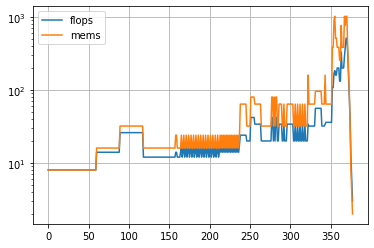

In [27]:
p = 3
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                    degree=3
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

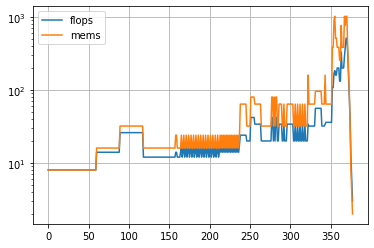

In [28]:
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                              degree=3, composer_type='cone'
                             )
plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

In [29]:
@ex.provider
def expectation_value(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    sim = qt.QtreeSimulator()
    E = sim.simulate(circuit)
    return E[0]

In [30]:
gamma = np.array([-1.358922, 0.40041, -1.101348])
beta = np.array([-0.6072757, -0.45687, 0.2329651])
gamma *= -1/np.pi
beta *= 1/np.pi
E = ex.get_variable('expectation_value', p=3, degree=3,
                    gamma=tuple(gamma), beta=tuple(beta))
print('Expectation', E)

beta, gamma (-0.1933018589491818, -0.14542623770078844, 0.07415509446579542) (0.4325583071526492, -0.12745446152685164, 0.3505699565287455) type cone
len 444
Expectation (-0.584775547118884-6.453171330633722e-16j)


In [31]:
@ex.add_function(provides=('beta', 'gamma'), requires='p')
def get_dummy_beta_gamma(p):
    beta = [.1]*p
    gamma = [.2]*p
    return tuple(beta), tuple(gamma)

## Bethe lattice subgraphs complexity estimation

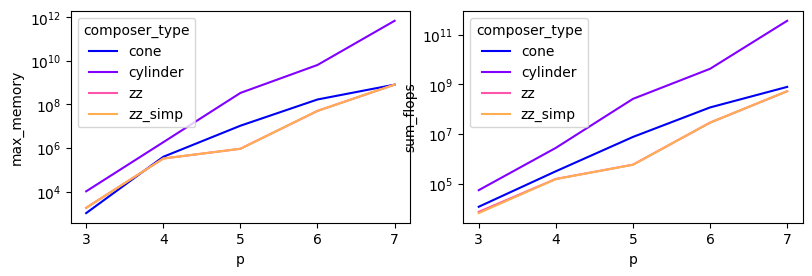

In [33]:
ps = [3, 4, 5, 6, 7]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3],
                    composer_type = ['cone', 'cylinder', 'zz', 'zz_simp'],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.yscale('log')

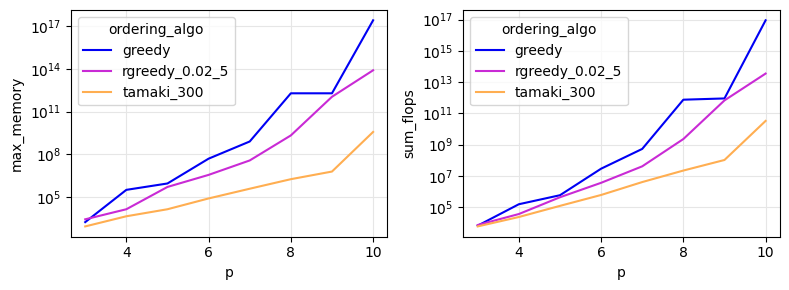

In [35]:
ps = [3, 4, 5, 6, 7, 8, 9, 10]
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.yscale('log')
    
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    plot_func=custom_plot,
                    degree = [3],
                    ordering_algo=['greedy', 'rgreedy_0.02_5', 'tamaki_300'],
                    composer_type = ['zz_simp'],
                    p=ps,
                   )


In [ ]:
ps = [4, 5, 6, 7, 8, 9, 10]
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.yscale('log')
    
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    plot_func=custom_plot,
                    degree = [3],
                    ordering_algo=['rgreedy_0.02_10', f'tamaki_{15*60}'],
                    composer_type = ['zz_simp'],
                    p=ps,
                   )


beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type old
my type is OldQtreeQAOAComposer
len 67406


KeyboardInterrupt: 

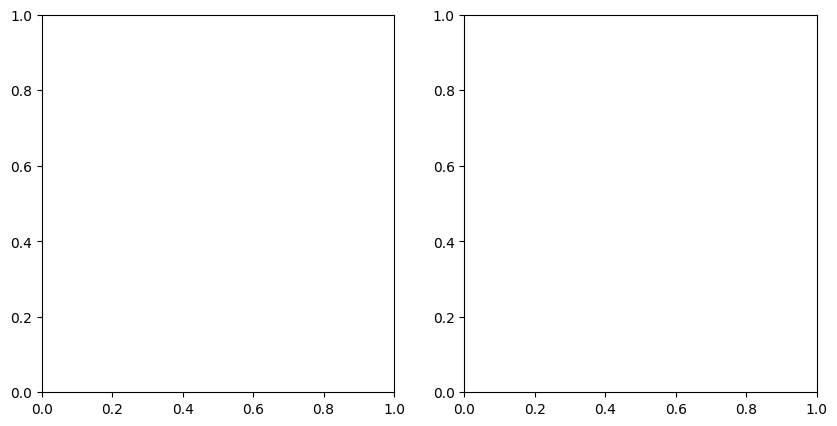

In [17]:
p = 8
f, axs = plt.subplots(1,2,figsize=(10, 5), dpi=100)
plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='old'
                   )


plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

for ax in axs:
    plt.sca(ax)
    plt.plot(flops, label='flops')
    plt.plot(mems, label='mems')
    plt.legend()
    plt.yscale('log')
    plt.grid()

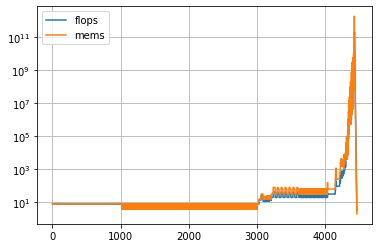

In [132]:
p = 8
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

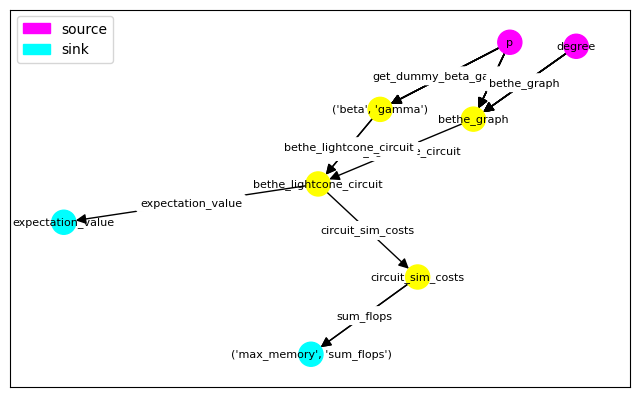

In [125]:
_ = ex.draw_dependency_graph()